In [88]:
import keras
from keras.layers.merge import concatenate
from keras.layers import Input, Dense,Embedding,Flatten,Dropout,Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
import pandas as pd
import numpy as np

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [89]:
path = 'ml-latest-small/'

In [90]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [91]:
len(ratings)

100004

In [92]:
pd.read_csv(path+'movies.csv').head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [93]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [94]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [95]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [96]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [97]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [98]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [99]:
n_factors = 300

In [100]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

In [101]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [102]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [103]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [107]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
save_best = ModelCheckpoint('CF.hdf', save_best_only=True, 
                           monitor='val_loss', mode='min')
history = nn.fit([trn.userId, trn.movieId],
        trn.rating,
        batch_size=32,
        validation_data=([val.userId, val.movieId], val.rating),
        epochs=120, callbacks=[early_stopping,save_best]
      )

Train on 80131 samples, validate on 19873 samples
Epoch 1/1
80131/80131 [==============================] - 688s 9ms/step - loss: 0.8678 - val_loss: 0.8806


In [108]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [109]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [110]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 300)

In [111]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

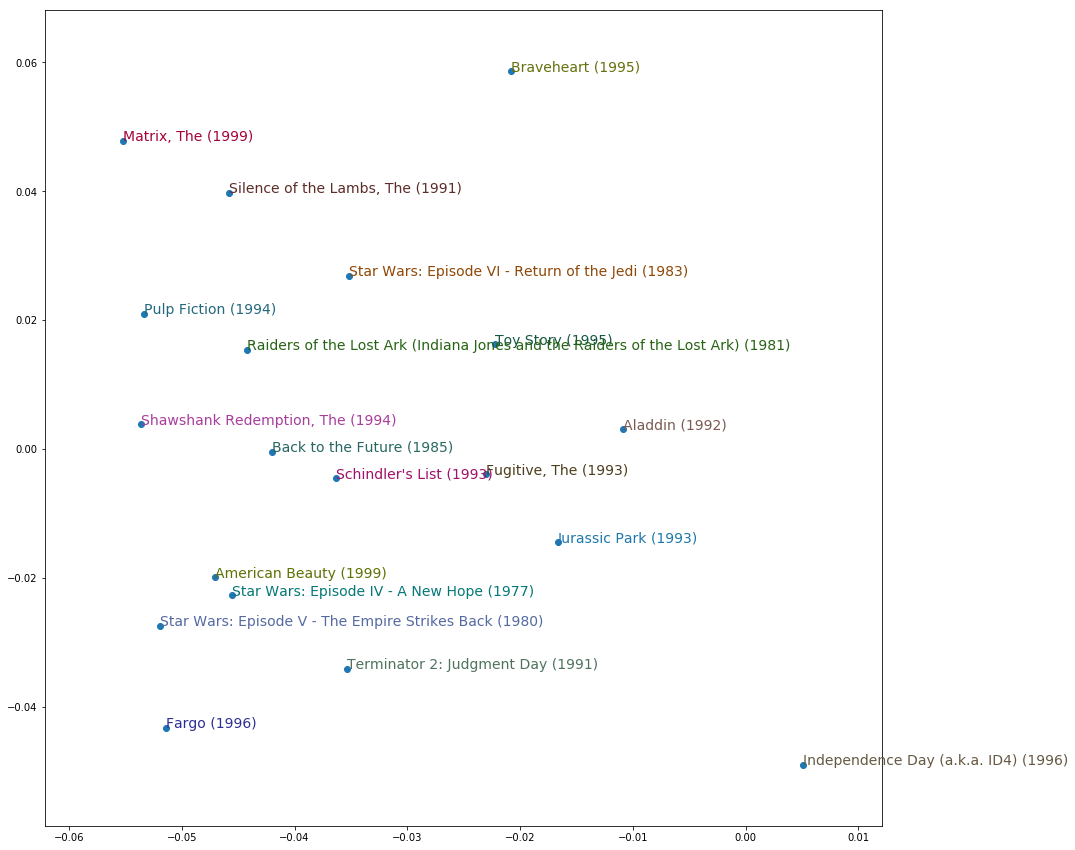

In [114]:
import matplotlib.pyplot as plt
fac0 = movie_pca[0]
fac1 = movie_pca[1]
fac2 = movie_pca[2]
start=1; end=20
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()